In [ ]:
from google.colab import drive

# 내 구글 드라이브에 접근
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# 필요한 라이브러리 import
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



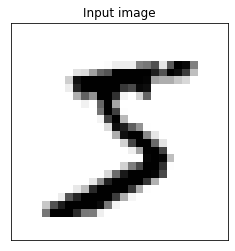

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28]) torch.float32
Shape of y [N]: torch.Size([64]) torch.int64


In [ ]:
input_size = 28 # MNIST 데이터셋의 크기 (28 * 28)

# 인풋을 텐서로 변환
transform=transforms.ToTensor()

# 공개 데이터셋에서 학습 데이터 다운로드
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

# 공개 데이터셋에서 검증 데이터 다운로드
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

image, label = training_data[0]

plt.title('Input image')
plt.imshow(image.reshape(input_size, input_size), cmap='gist_yarg')
plt.xticks([]),plt.yticks([])
plt.show()

# 데이터로더 생성
batch_size = 64 # 한번에 호출할 개수
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# 데이터로더는 iterable하게만 사용 가능
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}") # N은 batch_size, C는 컬러 채널 개수(흑백=1, 컬러=3)
    print(f"Shape of y [N]: {y.shape} {y.dtype}")
    break

In [ ]:
# CNN 모델 정의
kernel_size = 3

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size, 1, kernel_size//2, bias=False) # input_channel, output_channel, kernel_size, stride, padding
        self.conv2 = nn.Conv2d(32, 64, kernel_size, 1, kernel_size//2, bias=False)
        self.linear1 = nn.Linear(3136, 256, bias=False) # input_size, output_size
        self.linear2 = nn.Linear(256, 10, bias=False)

    def forward(self, x):
        # 실제 계산에서는 앞에 크기가 batch_size인 차원이 추가됨
        x = self.conv1(x) # 1 * 28 * 28 -> 32 * 28 * 28 (채널 32개로 증가)
        x = F.relu(x) # 활성화함수로 relu 사용
        x = F.avg_pool2d(x, 2) # 32 * 28 * 28 -> 32 * 14 * 14 (kernel_size가 2인 avg_pooling -> 크기가 절반으로 감소)
        x = self.conv2(x) # 32 * 14 * 14 -> 64 * 14 * 14 (채널 64개로 증가)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) # 64 * 14 * 14 -> 64 * 7 * 7 (kernel_size가 2인 max_pooling -> 크기가 절반으로 감소)
        x = torch.flatten(x, 1) # 64 * 7 * 7 -> 3136
        x = self.linear1(x) # 3136 -> 256
        x = F.relu(x)
        x = self.linear2(x) # 256 -> 10 (최종 출력형태)
        output = F.log_softmax(x, dim=1)
        return output

def train(dataloader, model, device, optimizer):
    model.train() # 학습 모드
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 예측 오류 계산
        pred = model(X)
        loss = F.nll_loss(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, device):
    model.eval() # 평가 모드
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += F.nll_loss(pred, y, reduction='sum').item()  # loss의 합 구하기
            maxIndex = pred.argmax(dim=1, keepdim=True)  # 최댓값의 index 구하기
            correct += maxIndex.eq(y.view_as(maxIndex)).sum().item() # maxIndex가 y와 같아야 맞는 경우임

    test_loss /= len(dataloader.dataset)
    print(f"Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(dataloader.dataset)} ({100. * correct / len(dataloader.dataset):.0f}%)\n")

In [ ]:
# 학습에 사용할 CPU 또는 GPU 장치 탐색
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = NeuralNetwork().to(device)
optimizer = torch.optim.Adadelta(model.parameters(), lr=1e-3)

epochs = 50 # 50번 반복 수행
start = time.time()  # 시작 시간

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, device, optimizer) # 모델 학습
    test(test_dataloader, model, device) # 모델 평가
print(f"Epoch {epochs}회 수행 시간: {time.time() - start}초") # 작업 수행 시간 출력

np.savetxt('drive/My Drive/Colab Notebooks/conv1.txt', model.conv1.weight.data.cpu().detach().numpy().reshape(32 * 1 * 3 * 3), delimiter=' ')
np.savetxt('drive/My Drive/Colab Notebooks/conv2.txt', model.conv2.weight.data.cpu().detach().numpy().reshape(64 * 32 * 3 * 3), delimiter=' ')
np.savetxt('drive/My Drive/Colab Notebooks/linear1.txt', model.linear1.weight.data.cpu().detach().numpy(), delimiter=' ')
np.savetxt('drive/My Drive/Colab Notebooks/linear2.txt', model.linear2.weight.data.cpu().detach().numpy(), delimiter=' ')

print(model)
print(model.conv1.weight.shape)
print(model.conv2.weight.shape)
print(model.linear1.weight.shape)
print(model.linear2.weight.shape)

Using cpu device
Epoch 1
-------------------------------
loss: 2.304369  [    0/60000]
loss: 2.297439  [ 6400/60000]
loss: 2.292019  [12800/60000]
loss: 2.291478  [19200/60000]
loss: 2.279137  [25600/60000]
loss: 2.274309  [32000/60000]
loss: 2.271374  [38400/60000]
loss: 2.263527  [44800/60000]
loss: 2.260000  [51200/60000]
loss: 2.253288  [57600/60000]
Test set: Average loss: 2.2561, Accuracy: 4927/10000 (49%)

Epoch 2
-------------------------------
loss: 2.260549  [    0/60000]
loss: 2.247819  [ 6400/60000]
loss: 2.242762  [12800/60000]
loss: 2.239462  [19200/60000]
loss: 2.221480  [25600/60000]
loss: 2.203309  [32000/60000]
loss: 2.192666  [38400/60000]
loss: 2.190957  [44800/60000]
loss: 2.169259  [51200/60000]
loss: 2.181532  [57600/60000]
Test set: Average loss: 2.1664, Accuracy: 6133/10000 (61%)

Epoch 3
-------------------------------
loss: 2.168759  [    0/60000]
loss: 2.159290  [ 6400/60000]
loss: 2.104456  [12800/60000]
loss: 2.134815  [19200/60000]
loss: 2.107124  [25600/

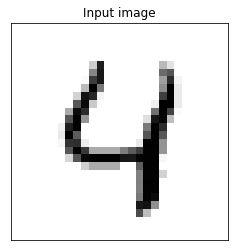

pred: tensor([[4]]), label: 4
추론 성공
tensor([[-11.2636, -17.7338,  -7.9031, -10.5444,  -0.0350,  -9.6029,  -8.0047,
          -7.1793,  -7.1562,  -3.4422]], grad_fn=<LogSoftmaxBackward0>)
tensor([[ -4.2536, -10.7238,  -0.8931,  -3.5344,   6.9750,  -2.5929,  -0.9947,
          -0.1693,  -0.1462,   3.5678]], grad_fn=<MmBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000

In [ ]:
image, label = test_data[4] # 예시로 출력할 검증 데이터

plt.title('Input image')
plt.imshow(image.reshape(input_size, input_size), cmap='gist_yarg')
plt.xticks([]),plt.yticks([])
plt.show()

result = model(image.reshape(1, 1, input_size, input_size).to(device)) # batch_size는 1인 경우와 동일
pred = result.argmax(dim=1, keepdim=True)

print(f'pred: {pred}, label: {label}')
print(f'{"추론 성공" if pred == label else "추론 실패"}')

print(result)
x = model.conv1(image.reshape(1, 1, input_size, input_size).to(device)) # 1 * 28 * 28 -> 32 * 28 * 28 (채널 32개로 증가)
x = F.relu(x) # 활성화함수로 relu 사용
x = F.avg_pool2d(x, 2) # 32 * 28 * 28 -> 32 * 14 * 14 (kernel_size가 2인 avg_pooling -> 크기가 절반으로 감소)
x = model.conv2(x) # 32 * 14 * 14 -> 64 * 14 * 14 (채널 64개로 증가)
x = F.relu(x)
x = F.max_pool2d(x, 2) # 64 * 14 * 14 -> 64 * 7 * 7 (kernel_size가 2인 max_pooling -> 크기가 절반으로 감소)
x = torch.flatten(x, 1) # 64 * 7 * 7 -> 3136
x = model.linear1(x) # 3136 -> 256
x = F.relu(x)
x = model.linear2(x)
print(x)
print(image.reshape(28 * 28))